In [3]:
# pip install ydata-profiling

In [4]:
from ydata_profiling import ProfileReport
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, date_format, regexp_replace
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
from pyspark.sql.window import Window

import matplotlib.pyplot as plt

In [5]:
# Inicializar una sesión de Spark
spark = SparkSession.builder \
    .appName("DataCleaning") \
    .getOrCreate()

In [6]:
# Ruta al archivo CSV dentro del contenedor
ruta_csv = "/home/jovyan/work/data/raw/df_MarbellaPuerto_daily.csv"
# Cargar el archivo CSV en un DataFrame de PySpark
df = spark.read.csv(ruta_csv, header=True, inferSchema=True)

In [7]:
df = df.orderBy("fecha")
df.show(5)

+----------+----------+----------------+---------+-------+----+----+----+--------+----+--------+---+--------+-----+---------+-------+-----+---------+-----+---------+
|     fecha|indicativo|          nombre|provincia|altitud|tmed|prec|tmin|horatmin|tmax|horatmax|dir|velmedia|racha|horaracha|hrMedia|hrMax|horaHrMax|hrMin|horaHrMin|
+----------+----------+----------------+---------+-------+----+----+----+--------+----+--------+---+--------+-----+---------+-------+-----+---------+-----+---------+
|2019-01-01|     6076X|MARBELLA, PUERTO|   MALAGA|      2|13,9| 0,0| 9,6|   06:31|18,2|   10:14| 33|     1,7|  5,0|    04:30|     63|   79|    18:20|   37|    10:00|
|2019-01-02|     6076X|MARBELLA, PUERTO|   MALAGA|      2|14,6| 0,0| 9,4|   07:32|19,9|   16:04| 35|     1,1|  6,1|    19:20|     56|   69|   Varias|   36|    21:00|
|2019-01-03|     6076X|MARBELLA, PUERTO|   MALAGA|      2|13,1| 0,0| 9,6|   06:22|16,6|   13:22|  6|     4,7| 10,6|    10:50|     70|   81|    23:30|   43|    03:00|
|201

In [8]:
df.tail(5)

[Row(fecha=datetime.date(2025, 1, 3), indicativo='6076X', nombre='MARBELLA, PUERTO', provincia='MALAGA', altitud=2, tmed='13,9', prec='0,0', tmin='9,5', horatmin='05:54', tmax='18,3', horatmax='10:21', dir=34, velmedia='3,1', racha='6,1', horaracha='01:50', hrMedia=72, hrMax=84, horaHrMax='18:50', hrMin=38, horaHrMin='23:40'),
 Row(fecha=datetime.date(2025, 1, 4), indicativo='6076X', nombre='MARBELLA, PUERTO', provincia='MALAGA', altitud=2, tmed='15,4', prec='0,0', tmin='10,2', horatmin='03:55', tmax='20,7', horatmax='14:56', dir=22, velmedia='2,5', racha='10,3', horaracha='13:30', hrMedia=41, hrMax=62, horaHrMax='23:40', hrMin=20, horaHrMin='09:30'),
 Row(fecha=datetime.date(2025, 1, 5), indicativo='6076X', nombre='MARBELLA, PUERTO', provincia='MALAGA', altitud=2, tmed='14,2', prec='31,6', tmin='11,0', horatmin='07:48', tmax='17,4', horatmax='10:32', dir=24, velmedia='4,4', racha='17,5', horaracha='18:20', hrMedia=64, hrMax=86, horaHrMax='Varias', hrMin=51, horaHrMin='17:50'),
 Row(fe

In [9]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+-----+----------+------+---------+-------+----+----+----+--------+----+--------+---+--------+-----+---------+-------+-----+---------+-----+---------+
|fecha|indicativo|nombre|provincia|altitud|tmed|prec|tmin|horatmin|tmax|horatmax|dir|velmedia|racha|horaracha|hrMedia|hrMax|horaHrMax|hrMin|horaHrMin|
+-----+----------+------+---------+-------+----+----+----+--------+----+--------+---+--------+-----+---------+-------+-----+---------+-----+---------+
|    0|         0|     0|        0|      0|  12| 403|  12|      12|  12|      12|  5|       1|    5|        5|      9|    7|        7|    7|        7|
+-----+----------+------+---------+-------+----+----+----+--------+----+--------+---+--------+-----+---------+-------+-----+---------+-----+---------+



In [10]:
# 1. Generar el rango de fechas en Pandas
date_range = pd.date_range("2019-01-01", "2025-01-07")
# 2. Convertir el rango de fechas a un DataFrame de PySpark
date_range_df = spark.createDataFrame(date_range.to_frame(name="fecha"), schema="fecha date")
# 3. Convertir las fechas a strings en PySpark
date_range_str = date_range_df.withColumn("fecha_str", date_format(col("fecha"), "yyyy-MM-dd"))
# 4. Convertir la columna 'fecha' del DataFrame original a strings
# Supongamos que ya tienes un DataFrame df con una columna 'fecha' de tipo date
df_fecha_str = df.withColumn("fecha_str", date_format(col("fecha"), "yyyy-MM-dd"))

# 5. Realizar la diferencia de conjuntos
# Primero, seleccionar solo las columnas de strings
date_range_str_set = date_range_str.select("fecha_str").distinct()
df_fecha_str_set = df_fecha_str.select("fecha_str").distinct()
# Hacer la diferencia usando una operación de left anti join
df_no_data = date_range_str_set.join(df_fecha_str_set, on="fecha_str", how="left_anti")
# 6. Renombrar la columna resultante
df_no_data = df_no_data.withColumnRenamed("fecha_str", "fecha")

# Mostrar el resultado
df_no_data.show()

+----------+
|     fecha|
+----------+
|2024-09-15|
|2024-09-10|
|2024-09-14|
|2024-09-07|
|2024-09-18|
|2024-09-19|
|2024-09-17|
|2024-09-16|
|2024-09-11|
|2024-09-09|
|2024-09-12|
|2024-09-08|
|2024-09-13|
+----------+



In [11]:
# Realizar un left join entre df_no_data y df
df = df_no_data.join(df, on="fecha", how="outer")

In [12]:
df.filter(col("fecha") == "2024-09-13").show()

+----------+----------+------+---------+-------+----+----+----+--------+----+--------+----+--------+-----+---------+-------+-----+---------+-----+---------+
|     fecha|indicativo|nombre|provincia|altitud|tmed|prec|tmin|horatmin|tmax|horatmax| dir|velmedia|racha|horaracha|hrMedia|hrMax|horaHrMax|hrMin|horaHrMin|
+----------+----------+------+---------+-------+----+----+----+--------+----+--------+----+--------+-----+---------+-------+-----+---------+-----+---------+
|2024-09-13|      NULL|  NULL|     NULL|   NULL|NULL|NULL|NULL|    NULL|NULL|    NULL|NULL|    NULL| NULL|     NULL|   NULL| NULL|     NULL| NULL|     NULL|
+----------+----------+------+---------+-------+----+----+----+--------+----+--------+----+--------+-----+---------+-------+-----+---------+-----+---------+



In [13]:
# Mostrar el esquema del DataFrame
df.printSchema()
# Mostrar las primeras filas del DataFrame
df.show(2)

root
 |-- fecha: date (nullable = true)
 |-- indicativo: string (nullable = true)
 |-- nombre: string (nullable = true)
 |-- provincia: string (nullable = true)
 |-- altitud: integer (nullable = true)
 |-- tmed: string (nullable = true)
 |-- prec: string (nullable = true)
 |-- tmin: string (nullable = true)
 |-- horatmin: string (nullable = true)
 |-- tmax: string (nullable = true)
 |-- horatmax: string (nullable = true)
 |-- dir: integer (nullable = true)
 |-- velmedia: string (nullable = true)
 |-- racha: string (nullable = true)
 |-- horaracha: string (nullable = true)
 |-- hrMedia: integer (nullable = true)
 |-- hrMax: integer (nullable = true)
 |-- horaHrMax: string (nullable = true)
 |-- hrMin: integer (nullable = true)
 |-- horaHrMin: string (nullable = true)

+----------+----------+----------------+---------+-------+----+----+----+--------+----+--------+---+--------+-----+---------+-------+-----+---------+-----+---------+
|     fecha|indicativo|          nombre|provincia|altitu

In [14]:
cols_numericas = ['tmed', 'prec', 'tmin', 'tmax', 'velmedia', 'racha']
# Iterar sobre la lista de columnas y aplicar las transformaciones
for columna in cols_numericas:
    df = df.withColumn(columna, regexp_replace(col(columna), ",", "."))  # Reemplazar coma por punto
    df = df.withColumn(columna, col(columna).cast("float"))  # Convertir a float

Crear el dataprofiling para observar los datos

In [15]:
# # Convertir el DataFrame de PySpark a Pandas
# pandas_df = df.toPandas()
# # Generar el reporte de profiling
# profile = ProfileReport(pandas_df, title="Marbella Daily Profiling Report")
# profile.to_file("/home/jovyan/work/EDA/pr_marbella_daily.html")

### Las variables seleccionadas para las predicciones son:
 - Temperatura media (tmed)
 - Temperatura maxima (tmax)
 - Temperatura minima (tmin)
 - Humedad media en % (hrMedia)

##### Estas variables después de observar el resultado del Profile Report, se ha decidido que su valor depende de las siguientes columnas:
 - fecha,  y las variables pertinentes (tmed, tmin, tmax y hrMedia)

##### Para el analisis de los datos, vamos a eliminar las columnas que no consideramos necesarias:
 - indicativo, nombre, provincia, altitud, horatmin, horatmax, dir, horaracha, horaHrMax, horaHrMin, prec, velmedia, racha, hrMax, hrMin

In [16]:
# Lista de columnas a eliminar
columnas_a_eliminar = ["indicativo", "nombre", "provincia", "altitud", "horatmin", "horatmax", "dir", "horaracha", "horaHrMax", "horaHrMin",  
                       "prec", "velmedia", "racha", "hrMax", "hrMin"]
# Eliminar las columnas definidas en la lista
df = df.drop(*columnas_a_eliminar)

##### Estudio de los datos de la columna fecha:
 - Los datos recopilados entre 2019-01-01 y 2025-01-07 para el estudio, deben sumar un total de 2193 registros (1 por dia)
 - El dataset contiene 2204, con 11 registros duplicados, por lo cual se quedaria en 2193 registros, asi que se deben eliminar los duplicados

In [17]:
# Convertir la columna 'fecha' a tipo fecha (si no está en ese formato)
df = df.withColumn("fecha", F.to_date(F.col("fecha")))

In [18]:
print(len(pd.date_range("2019-01-01", "2025-01-07")), df.count())

2199 2211


In [19]:
df = df.dropDuplicates()

##### Estudio de los datos de la columna tmed, tmax, tmin y hrMedia:
 - tenemos 25 valores nulos en tmed, tmax y tmin, lo cual representa un 1.1% de los datos por columna, imputaremos temperaturas basadas en la media de los datos consecutivos anterior y posterior
 - tenemos 22 valores nulos en hrMedia, lo cual representa un 1% de los datos, realizaremos la misma imputacion como media de los valores no nulos consecutivos

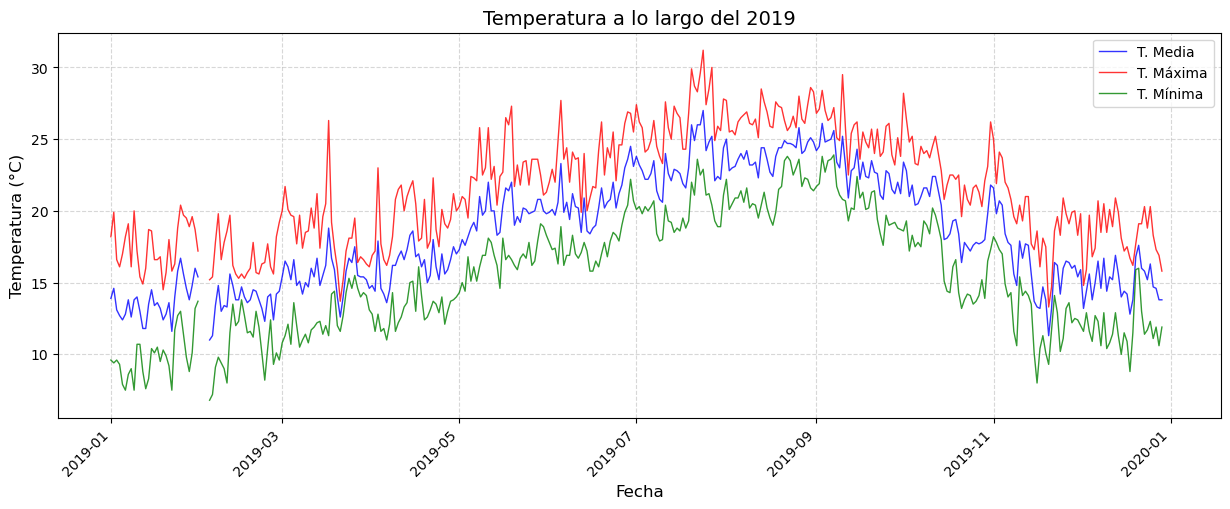

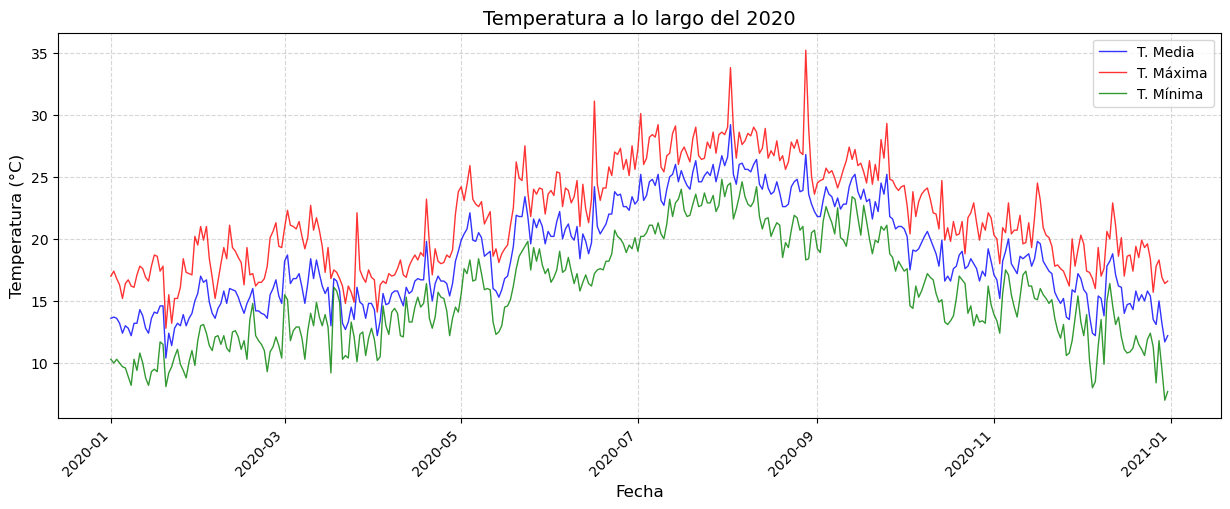

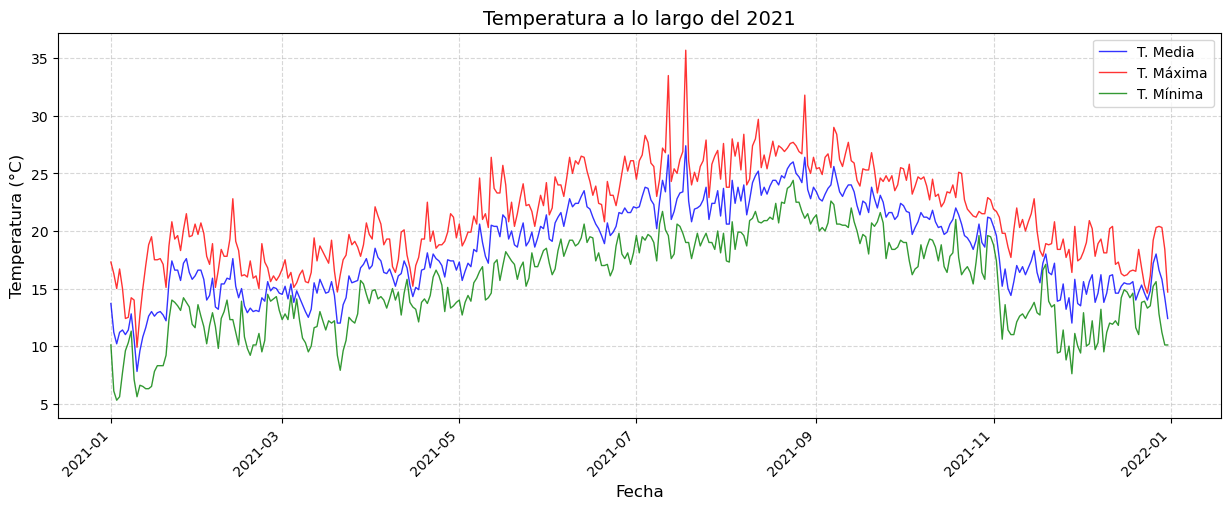

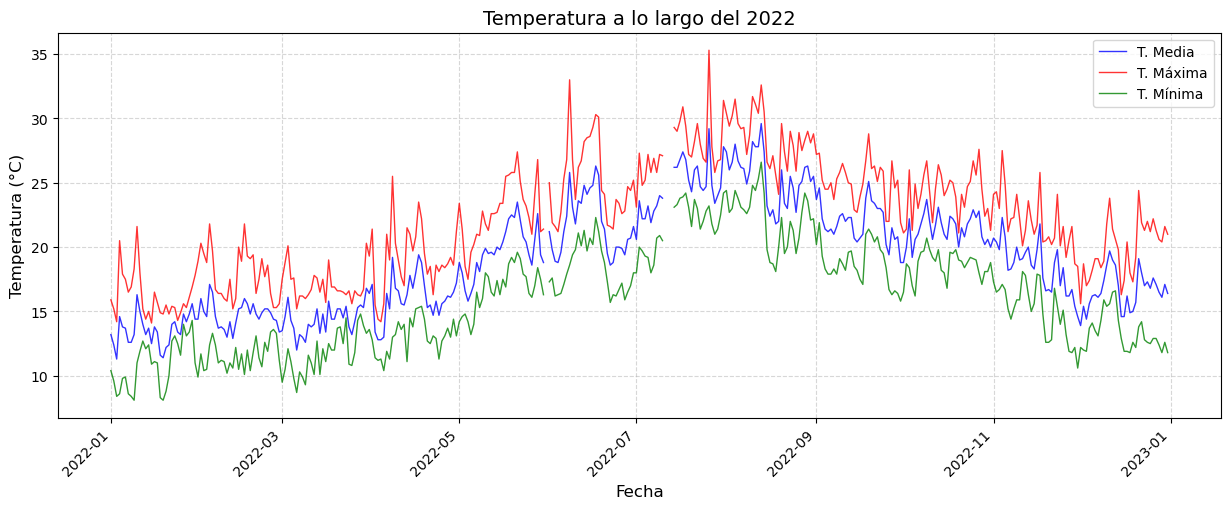

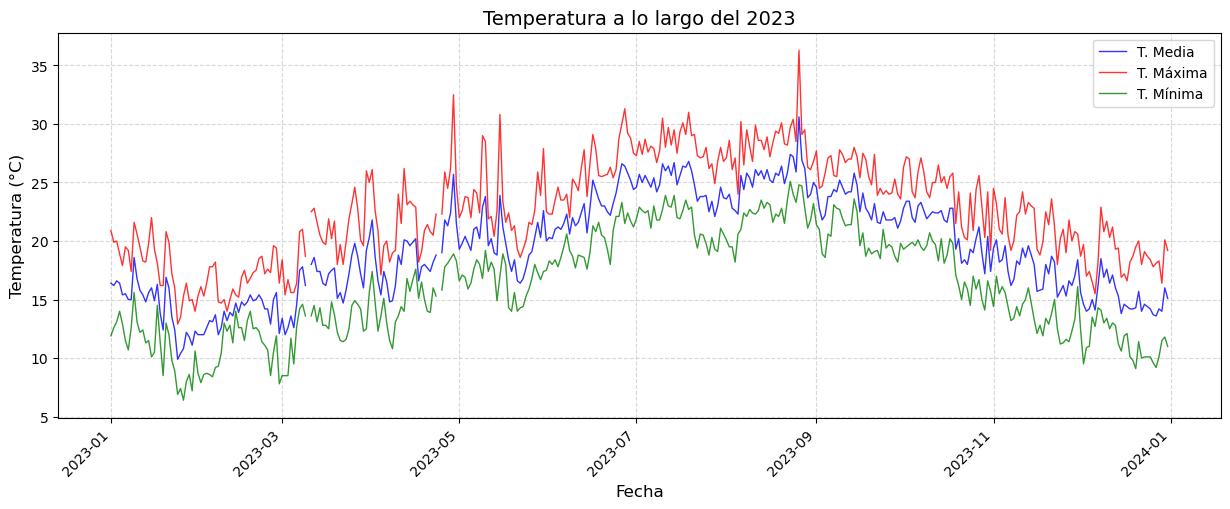

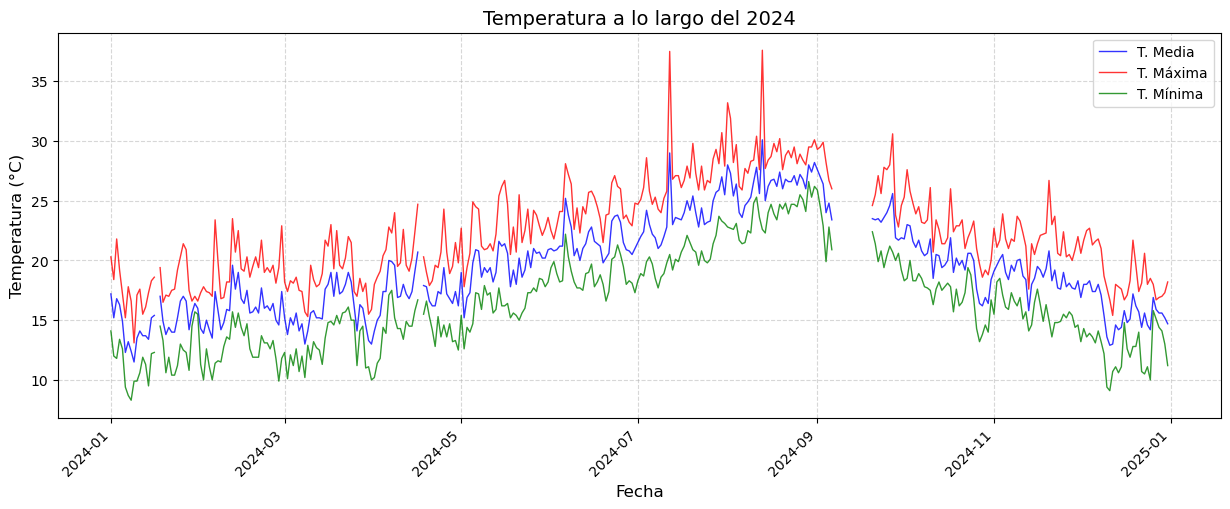

In [20]:
df_pandas = df.toPandas()
# Convertir la columna 'fecha' a tipo datetime si no lo está
df_pandas['fecha'] = pd.to_datetime(df_pandas['fecha'])

# Ordenar el DataFrame por fecha
df_pandas = df_pandas.sort_values(by='fecha')

# Obtener los años únicos en el DataFrame
años_unicos = df_pandas['fecha'].dt.year.unique()

# Generar un gráfico por cada año
for año in años_unicos[:6]:
    df_anual = df_pandas[df_pandas['fecha'].dt.year == año]
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_anual['fecha'], df_anual['tmed'], linestyle='-', color='b', linewidth=1, alpha=0.8, label='T. Media')
    plt.plot(df_anual['fecha'], df_anual['tmax'], linestyle='-', color='r', linewidth=1, alpha=0.8, label='T. Máxima')
    plt.plot(df_anual['fecha'], df_anual['tmin'], linestyle='-', color='g', linewidth=1, alpha=0.8, label='T. Mínima')
    # plt.plot(df_anual['fecha'], df_anual['tmed'], linestyle='-', color='b', linewidth=1, alpha=0.8, label='T. Media')
    # plt.plot(df_anual['fecha'], df_anual['tmed_media_movil_7d'], linestyle='-', color='r', linewidth=1, alpha=0.8, label='T. Media MA')
    
    # Etiquetas y título
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Temperatura (°C)', fontsize=12)
    plt.title(f'Temperatura a lo largo del {año}', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')

    # Mostrar el gráfico
    plt.show()

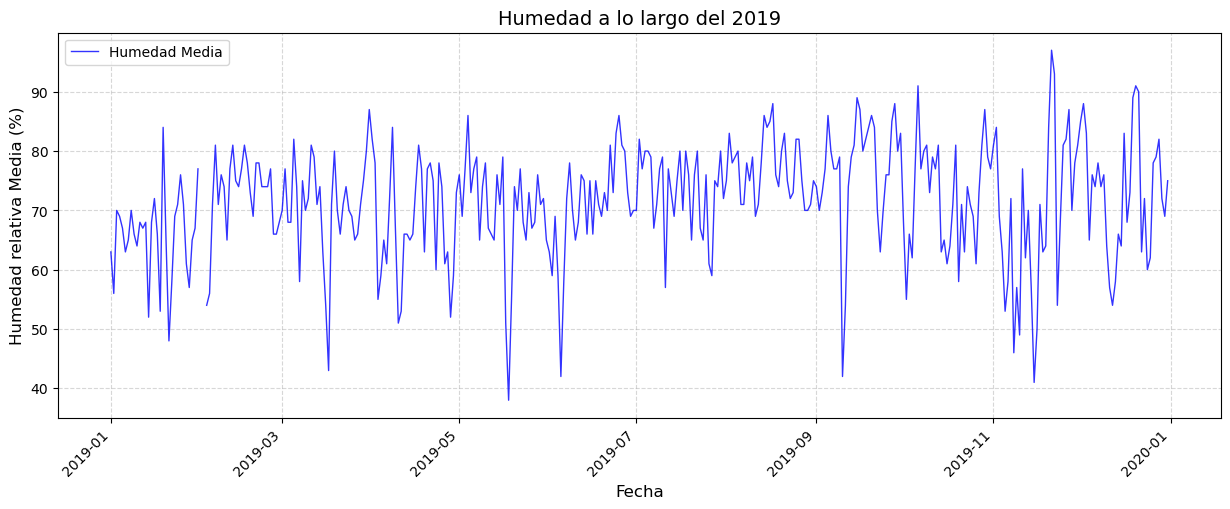

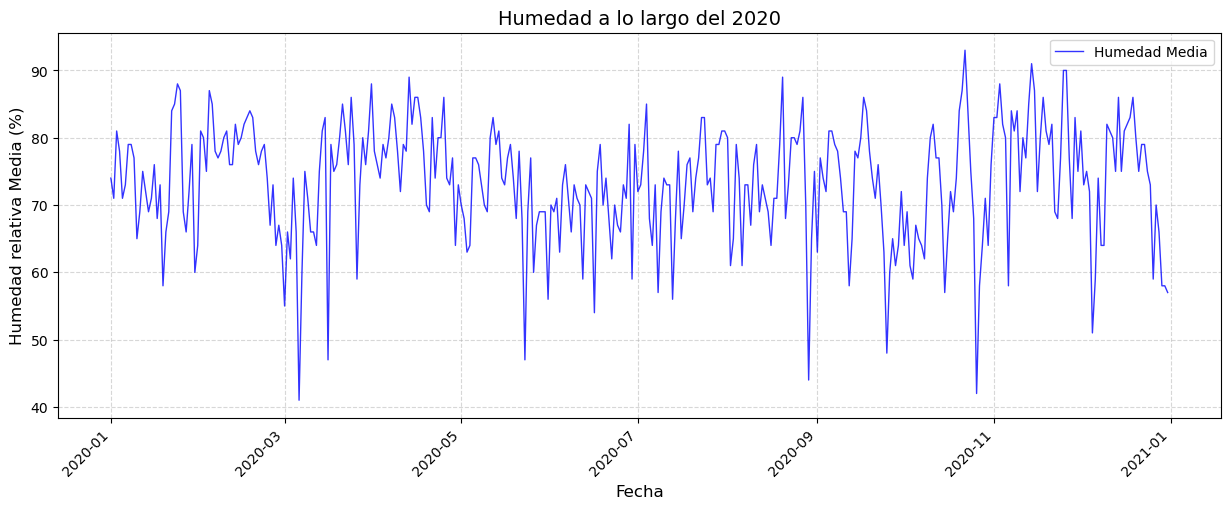

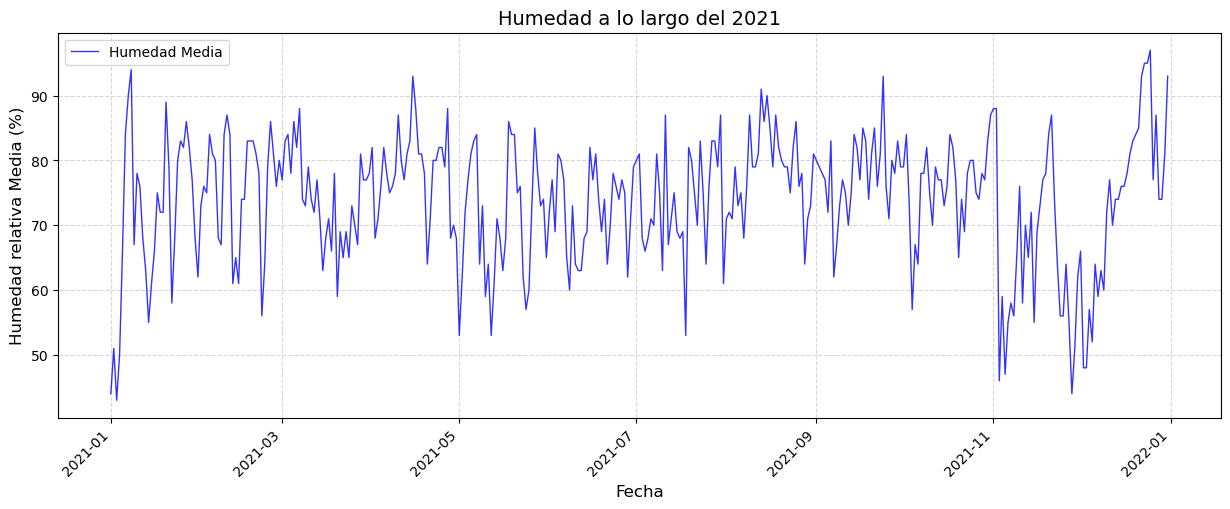

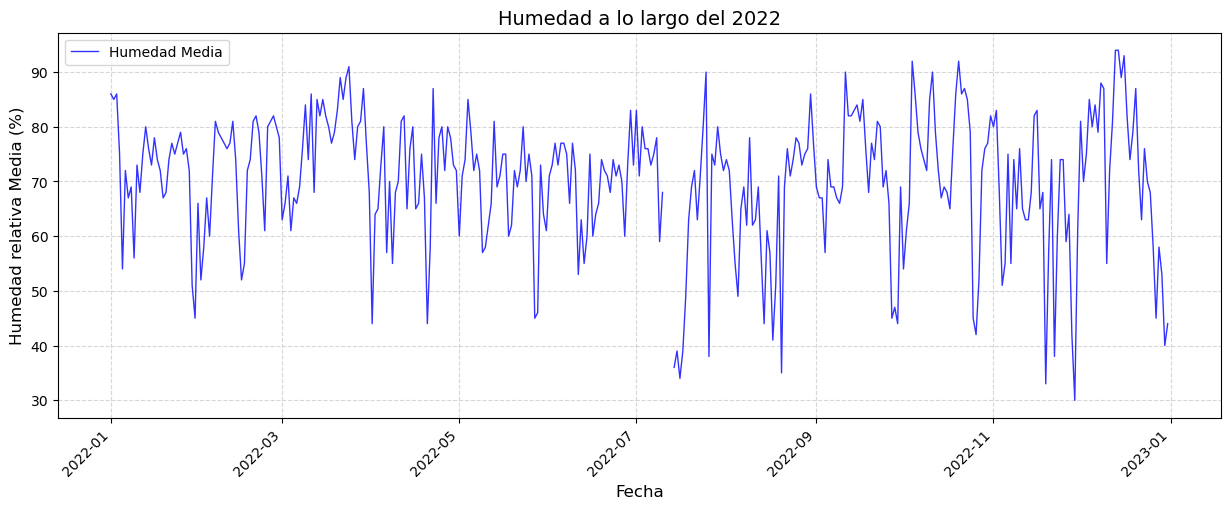

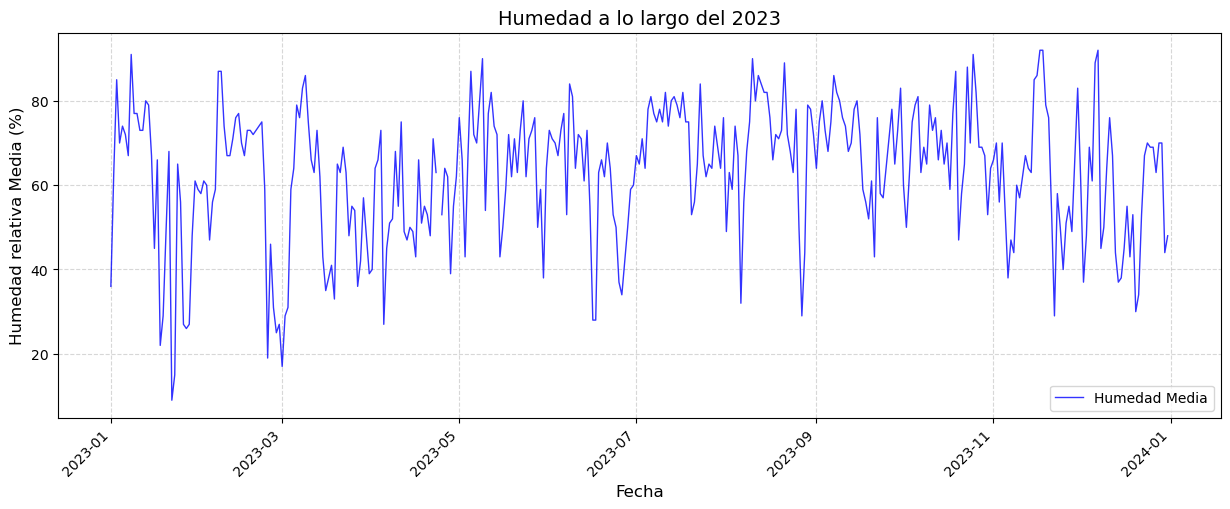

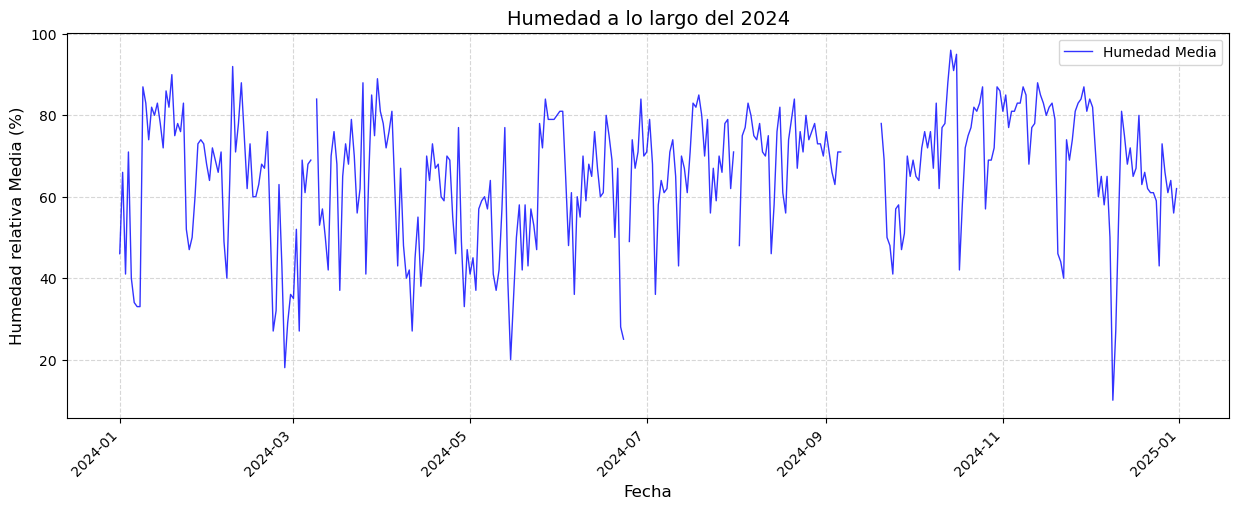

In [21]:
df_pandas = df.toPandas()
# Convertir la columna 'fecha' a tipo datetime si no lo está
df_pandas['fecha'] = pd.to_datetime(df_pandas['fecha'])

# Ordenar el DataFrame por fecha
df_pandas = df_pandas.sort_values(by='fecha')

# Obtener los años únicos en el DataFrame
años_unicos = df_pandas['fecha'].dt.year.unique()

# Generar un gráfico por cada año
for año in años_unicos[:6]:
    df_anual = df_pandas[df_pandas['fecha'].dt.year == año]
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_anual['fecha'], df_anual['hrMedia'], linestyle='-', color='b', linewidth=1, alpha=0.8, label='Humedad Media')
    
    # Etiquetas y título
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Humedad relativa Media (%)', fontsize=12)
    plt.title(f'Humedad a lo largo del {año}', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, ha='right')

    # Mostrar el gráfico
    plt.show()

In [22]:
# Función para rellenar valores nulos en una columna dada
def fill_nulls_with_mean_between_prev_next(df, col_name):
    # Definir una ventana para calcular el valor anterior y siguiente, ordenada por 'fecha'
    window_spec = Window.orderBy("fecha")

    # Obtener el valor anterior no nulo y el siguiente no nulo
    df = df.withColumn(f"prev_{col_name}", F.last(F.col(col_name), ignorenulls=True).over(window_spec.rowsBetween(Window.unboundedPreceding, -1)))
    df = df.withColumn(f"next_{col_name}", F.first(F.col(col_name), ignorenulls=True).over(window_spec.rowsBetween(0, Window.unboundedFollowing)))

    # Calcular la media entre el valor anterior y el siguiente
    df = df.withColumn(f"mean_{col_name}", (F.col(f"prev_{col_name}") + F.col(f"next_{col_name}")) / 2)

    # Rellenar los valores nulos en la columna con la media calculada
    df = df.withColumn(col_name, F.coalesce(F.col(col_name), F.col(f"mean_{col_name}")))

    # Eliminar columnas temporales
    df = df.drop(f"prev_{col_name}", f"next_{col_name}", f"mean_{col_name}")

    return df

In [23]:
# Lista de columnas a procesar
columns_to_fill = ["tmed", "tmax", "tmin", "hrMedia"]

In [24]:
# Aplicar la función a cada columna
for column in columns_to_fill:
    df = fill_nulls_with_mean_between_prev_next(df, column)

In [25]:
df.filter(col("fecha") == "2024-09-13").show()

+----------+------------------+------------------+------------------+-------+
|     fecha|              tmed|              tmin|              tmax|hrMedia|
+----------+------------------+------------------+------------------+-------+
|2024-09-13|23.450000762939453|21.649999618530273|25.299999237060547|   74.5|
+----------+------------------+------------------+------------------+-------+



In [26]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+-----+----+----+----+-------+
|fecha|tmed|tmin|tmax|hrMedia|
+-----+----+----+----+-------+
|    0|   0|   0|   0|      0|
+-----+----+----+----+-------+



##### Guardar el dataset limpio de datos

In [27]:
# Guardar el DataFrame limpio en un nuevo archivo CSV (opcional)
ruta_guardado = "/home/jovyan/work/data/processed/df_marbella_daily_cleaned.csv"
df.write.csv(ruta_guardado, header=True, mode="overwrite")

In [28]:
# Detener la sesión de Spark
spark.stop()